# Data and Imports

In [178]:
import os
import urllib
import math
import random

import numpy as np

from sklearn import datasets
from typing import Sequence, Union, List, Tuple
from numpy.linalg import norm
from tqdm import tqdm

from LogisticRegression import logistic_regression_loss, logistic_regression_L_estimation, logistic_regression_gradient

np.random.seed(69)
random.seed(69)

In [179]:
DATASET_URL = "https://www.csie.ntu.edu.tw/~cjlin/libsvmtools/datasets/binary/w8a"
data_path = './w8a'
if not os.path.exists(data_path):
    f = urllib.request.urlretrieve(DATASET_URL, data_path)
DATA, LABELS = datasets.load_svmlight_file(data_path)
LABELS = LABELS * (LABELS == 1)

In [180]:
def split_into_batches(X: np.ndarray,
                       batch_size: int, 
                       y: np.ndarray=None,
                       even_split: bool = True
                       ) -> Union[Tuple[Sequence[np.ndarray], Sequence[np.ndarray]], Sequence[np.ndarray]]:
    """A function to split the data into batches. I discard shuffling in this function to make sure 
    the output is deterministic for the same 'X'

    Args:
        X (np.ndarray): The data samples
        batch_size (int): 
        y (np.ndarray, optional): labels. Defaults to None.
        even_split (bool, optional): Whether to have all batches split evenly. Defaults to True.

    Returns:
        Union[Tuple[Sequence[np.ndarray], Sequence[np.ndarray]], Sequence[np.ndarray]]: the data batches, [Optional] the label batches 
    """
    # set the seed for reproducibility
    np.random.seed(31)

    # shuffle the data
    index = np.arange(X.shape[0])
    np.random.shuffle(index)
    X = X[index]
    y = y[index]
    
    # convert the batch size to 'int'
    batch_size = int(batch_size)
    
    # make sure to raise an error if the number of samples cannot be split into even batches (in case of 'even_split' is True)
    if even_split and X.shape[0] % batch_size != 0:
        raise ValueError((f"Please pass a batch size that can split the data evenly or set 'even_split' to False.\n" 
                         f"The number of samples: {len(X)}. The batch size: {batch_size}"))
    
    if y is not None: 
        # make sure the number of samples is the same as that of the number of labels
        if X.shape[0] != y.shape[0]:
            raise ValueError(f"The number of samples should be the same as the number of labels.")

        # y = np.expand_dims(y, axis=-1) if y.ndim == 1 else y        

    if y is not None:
        return [X[i: i + batch_size] for i in range(0, X.shape[0], batch_size)], [y[i: i + batch_size] for i in range(0, y.shape[0], batch_size)]

    return [X[i: i + batch_size] for i in range(0, X.shape[0], batch_size)]


In [ ]:
def split_into_batches(X: np.ndarray,
                       batch_size: int, 
                       y: np.ndarray=None,
                       even_split: bool = True
                       ) -> Union[Tuple[Sequence[np.ndarray], Sequence[np.ndarray]], Sequence[np.ndarray]]:
    """A function to split the data into batches. I discard shuffling in this function to make sure 
    the output is deterministic for the same 'X'

    Args:
        X (np.ndarray): The data samples
        batch_size (int): 
        y (np.ndarray, optional): labels. Defaults to None.
        even_split (bool, optional): Whether to have all batches split evenly. Defaults to True.

    Returns:
        Union[Tuple[Sequence[np.ndarray], Sequence[np.ndarray]], Sequence[np.ndarray]]: the data batches, [Optional] the label batches 
    """
    # set the seed for reproducibility
    np.random.seed(31)

    # shuffle the data
    index = np.arange(X.shape[0])
    np.random.shuffle(index)
    X = X[index]
    y = y[index]
    
    # convert the batch size to 'int'
    batch_size = int(batch_size)
    
    # make sure to raise an error if the number of samples cannot be split into even batches (in case of 'even_split' is True)
    if even_split and X.shape[0] % batch_size != 0:
        raise ValueError((f"Please pass a batch size that can split the data evenly or set 'even_split' to False.\n" 
                         f"The number of samples: {len(X)}. The batch size: {batch_size}"))
    
    if y is not None: 
        # make sure the number of samples is the same as that of the number of labels
        if X.shape[0] != y.shape[0]:
            raise ValueError(f"The number of samples should be the same as the number of labels.")

        # y = np.expand_dims(y, axis=-1) if y.ndim == 1 else y        

    if y is not None:
        return [X[i: i + batch_size] for i in range(0, X.shape[0], batch_size)], [y[i: i + batch_size] for i in range(0, y.shape[0], batch_size)]

    return [X[i: i + batch_size] for i in range(0, X.shape[0], batch_size)]


In [181]:
# !pip install git+https://github.com/konstmish/opt_methods.git

In [182]:
NUM_DEVICES = 16
DEVICES_DATA, DEVICES_LABELS = split_into_batches(DATA, y=LABELS, even_split=False, batch_size=int(math.ceil(DATA.shape[0] /NUM_DEVICES)))

In [183]:
from optmethods.loss import LogisticRegression
# let's estimate 'L' correctly
# def L_estimation(device_batches, label_batches) -> float:
#     our_l = float('-inf')
#     for d_data, d_label in zip(device_batches, label_batches):
#         l = logistic_regression_L_estimation(d_data.toarray(), d_label, np.random.randn(d_data.shape[1], 1))
#         our_l = max(our_l, l)
#     return our_l            


def L_estimation(device_batches, label_batches) -> float:
    our_l = float('-inf')
    for d_data, d_label in zip(device_batches, label_batches):
        loss = LogisticRegression(d_data, d_label, l1=0, l2=0)
        l = loss.smoothness
        our_l = max(our_l, l)
    return our_l            


PROBLEM_L = L_estimation(DEVICES_DATA, DEVICES_LABELS)
PROBLEM_LAMBDA = PROBLEM_L * 10 ** -4

In [184]:
PROBLEM_L

0.6914564086632117

In [185]:
from functools import partial
def lr_loss(X: np.ndarray, y: np.ndarray, w: np.ndarray, lam):
    return LogisticRegression(X, y, l1=0, l2=lam).value(w)

def lr_gradient(X: np.ndarray, y:np.ndarray, w: np.ndarray, lam: float):
    w = w.squeeze()
    grad = LogisticRegression(X, y, l1=0, l2=lam).gradient(w)  
    
    if grad.ndim >= 2 and grad.shape[1] != 1:
        raise ValueError(f"Gradident calculation went wrong: {grad.shape}") 
    if grad.ndim == 1:
        grad = grad.reshape(-1, 1)
        
    return grad

FUNCTION = partial(lr_loss, lam=PROBLEM_LAMBDA)
GRADIENT_FUNCTION = partial(lr_gradient, lam=PROBLEM_LAMBDA)

In [186]:
# create the set up: x_0 and seed
def set_up(seed: int = 69) -> np.ndarray:
        # changing the seed mainly changes the starting point
    random.seed(seed)
    np.random.seed(seed)
    w_0 = np.random.randn(DATA.shape[1], 1)
    return w_0

In [187]:
# for i in range(0, DATA.shape[0], 1000):
#     d_data = DATA[i : i + 1000]
#     d_labels = LABELS[i : i + 1000]
#     w = np.random.randn(d_data.shape[1])
#     l = LogisticRegression(d_data, d_labels, l1=0, l2=0)
#     v1 = l.value(w)
#     v2 = logistic_regression_loss(d_data.toarray(), d_labels, w=w.reshape(-1, 1), lam=0)
#     print(np.abs(v1 - v2))

In [188]:
# find the solution to the problem:

import os
import pickle
from scipy.optimize import minimize

if not os.path.exists('true_min.pkl'):
    # Finding true minimum to compare with
    def loss(w):
        return lr_loss(X=DATA, y=LABELS, w=w, lam=PROBLEM_LAMBDA)

    res = minimize(loss, np.random.rand(DATA.shape[1]), method='BFGS', tol=10 ** -6)
    TRUE_MIN = res.fun
    pickle.dump(TRUE_MIN, open('true_min.pkl', 'wb'))
    print(res)
else:
    with open('true_min.pkl', 'rb') as f:
        TRUE_MIN = pickle.load(f)

In [189]:
TRUE_MIN

0.13741784372775287

# Local Gradient Descent

In [190]:
def x_difference(x1: np.ndarray, x2: np.ndarray) -> float:
    """Computes the euclidean norm of the difference vector 

    Args:
        x1 (np.ndarray): first vector
        x2 (np.ndarray): second vector

    Returns:
        float: returns the norm of the difference
    """
    return norm(x1 - x2, ord=2)

def f_difference(f1: float, f2: float) -> float:
    """returns the absolute difference between 2 values """
    # the expression f_x_k - f_sol is equivalent since the problem is minimization,
    # but the 'abs' function was used to make the method general and not only specific to the given problem
    return abs(f1 - f2)      

# let's define the modes in terms of strings
x_diff = 'x_k+1 - x_k'
f_diff = 'f(x_k+1) - f(x_k)'
normalized_criterion = 'df_xk / df_x0'
x_opt_diff = 'x* - x_k'

In [191]:
def local_GD(
    num_local_steps:int,
    device_data: Sequence[np.ndarray],
    device_labels: Sequence[np.ndarray],
    function: callable,
    gradient_function: callable,
    x_0: np.ndarray,
    x_sol: np.ndarray=None,
    K: int = 10 ** 3,
    eps: float = 10 ** -5, 
    mode: str = normalized_criterion,
    gamma_k: callable = None,                      
    return_history: bool = True
    ) -> Union[List[np.ndarray], np.ndarray]:

    # the first step is to make sure the 'mode' variable is defined above
    if isinstance(mode , str) and mode not in [f_diff, x_diff, normalized_criterion, x_opt_diff]:
        raise ValueError((f"the variable 'mode' is expected to belong to {[f_diff, x_diff, normalized_criterion, x_opt_diff]}"
                          f"Found: {mode}"))
    
    if mode == x_opt_diff and x_sol is None: 
        raise ValueError(f"using mode = {x_opt_diff} requires passing the solution to the problem")

    # make sure the number of local_steps is at least 1
    num_local_steps = max(1, num_local_steps)

    x_current = np.expand_dims(x_0) if x_0.ndim == 1 else x_0
    x_history = [x_current]
    criterion_history = []

    # first initialize all the devices with the same x0
    xts = [x_0.copy() for _ in range(len(device_data))]

    for k in tqdm(range(math.ceil(K / num_local_steps))):
        x_previous = x_current.copy()
        gamma = gamma_k(k)

        # iterate through each of the devices
        for device_index, (d_data, d_label) in enumerate(zip(device_data, device_labels)):
            # perform consecutive 'num_local_steps' updates
            for _ in range(num_local_steps):
                xts[device_index] = xts[device_index] - gamma * gradient_function(d_data, d_label, xts[device_index]) 

        # average the local weights
        avg_xt = np.mean(xts, axis=0).reshape(-1, 1)

        if avg_xt.shape != (device_data[0].shape[1], 1):
            raise ValueError(f"Make sure the average operation is carried successfully, mf !!. Found the following shape: {avg_xt.shape}")

        # set the local weights to the averaged weight
        xts = [avg_xt.copy() for _ in xts]

        # set the 'x_current' to the averged weight
        x_current = avg_xt.copy()

        if mode == f_diff:
            x_current_function_value = np.mean([function(d_data, d_label, x_current) for d_data, d_label in zip(device_data, device_labels)])
            x_previous_function_value = np.mean([function(d_data, d_label, x_previous) for d_data, d_label in zip(device_data, device_labels)])
            diff = f_difference(x_current_function_value, x_previous_function_value)
        
        elif mode == x_diff:
            diff = x_difference(x_current, x_previous)
        
        elif mode == normalized_criterion:
            x0_grad = np.mean([gradient_function(d_data, d_label, x_0) for d_data, d_label in zip(device_data, device_labels)], axis=0).reshape(-1, 1)
            current_grad = np.mean([gradient_function(d_data, d_label, x_current) for d_data, d_label in zip(device_data, device_labels)], axis=0).reshape(-1, 1)
            diff = norm(current_grad) / norm(x0_grad)
        
        elif mode == x_opt_diff: 
            diff = norm(x_current - x_sol, ord=2)
        
        else: 
            # the last case is where the criterion is passed as an argument
            diff = mode(x_current)

        criterion_history.append(diff)
        # add 'x_current' to the history
        x_history.append(x_current)
            
        if diff <= eps: 
            break

        assert len(x_history) == k + 2, f"expected {k + 2} points. Found: {len(x_history)}"

    return  (x_history, criterion_history) if return_history else x_history[-1]

In [192]:
class LocalGDDevice:
    def __init__(self,
                 function: callable, 
                 gradient_function: callable, 
                 data: np.ndarray,
                 labels: np.ndarray,
                 num_local_steps: int
                 ) -> None:
        self.data = data
        self.labels = labels

        self.function = function
        self.gradient_function = gradient_function 

        self.H = num_local_steps

    def grad_step(self, x_current: np.ndarray, step_size: float) -> np.ndarray:  
        x = x_current.copy()
        for _ in range(self.H):
            grad = self.gradient_function(self.data,
                                          self.labels,
                                          x)
            x = x - step_size * grad
        return x

    def local_grad(self, x_current) -> np.ndarray:
        return self.gradient_function(self.data,
                                      self.labels,
                                      x_current)
        
    def local_function(self, x_current: np.ndarray) -> float:
        return self.function(self.data, self.labels, x_current)


class LocalSGDDevice:
    def __init__(self, 
                 function: callable,                   
                 gradient_function: callable, 
                 data: np.ndarray,
                 labels: np.ndarray,
                 num_local_steps: int,
                 batch_size: int
                 ) -> None:
        self.data = data
        self.labels = labels

        self.function = function
        self.gradient_function = gradient_function 
        
        self.H = num_local_steps
        
        self.batch_size = batch_size
        self.num_batches = int(math.ceil(len(self.data)) / self.batch_size )


    def local_function(self, x_current: np.ndarray) -> float:
        return self.function(self.data, self.labels, x_current)

    def grad_step(self, 
                   x_current: np.ndarray, 
                   step_size: float) -> np.ndarray:  
        x = x_current.copy()
        for _ in range(self.H):
            batch_index = random.randint(0, self.num_batches - 1)
            data, labels = self.data[batch_index * self.batch_size: (batch_index + 1) * self.batch_size]
            grad = self.gradient_function(data,
                                          labels,
                                          x)
            x = x - step_size * grad
        return x


In [193]:
# def local_GD(
#     num_local_steps:int,
#     local_devices: Sequence[LocalGDDevice],
#     x_0: np.ndarray,
#     x_sol: np.ndarray=None,
#     K: int = 10 ** 3,
#     eps: float = 10 ** -5, 
#     mode: str = normalized_criterion,
#     gamma_k: callable = None,                      
#     return_history: bool = True
#     ) -> Union[List[np.ndarray], np.ndarray]:

#     # the first step is to make sure the 'mode' variable is defined above
#     if isinstance(mode , str) and mode not in [f_diff, x_diff, normalized_criterion, x_opt_diff]:
#         raise ValueError((f"the variable 'mode' is expected to belong to {[f_diff, x_diff, normalized_criterion, x_opt_diff]}"
#                           f"Found: {mode}"))
    
#     if mode == x_opt_diff and x_sol is None: 
#         raise ValueError(f"using mode = {x_opt_diff} requires passing the solution to the problem")

#     # make sure the number of local_steps is at least 1
#     num_local_steps = max(1, num_local_steps)

#     x_current = np.expand_dims(x_0) if x_0.ndim == 1 else x_0
#     x_history = [x_current]
#     criterion_history = []

#     for k in tqdm(range(math.ceil(K / num_local_steps))):
#         x_previous = x_current.copy()
#         gamma = gamma_k(k)

#         local_xs = np.concatenate([d.grad_step(x_current=x_current, step_size=gamma) for d in local_devices], axis=1)
#         x_current = np.mean(local_xs, axis=1).reshape(-1, 1)

#         if mode == f_diff:
#             # the value of the function at 'x_current' is the average of the values of the local functions both at 'x_current' and 'x_previous'
#             x_current_function_value = np.mean([d.local_function(x_current=x_current) for d in local_devices])
#             x_previous_function_value = np.mean([d.local_function(x_current=x_previous) for d in local_devices])    
#             diff = f_difference(x_current_function_value, x_previous_function_value)
        
#         elif mode == x_diff:
#             diff = x_difference(x_current, x_previous)
        
#         elif mode == normalized_criterion:
#             # calculate the gradient at 'x_current' which is already calculated
#             local_grads_x0 = np.concatenate([d.local_grad(x_current=x_0, step_size=gamma) for d in local_devices], axis=1)
#             x0_grad = np.mean(local_grads_x0, axis=1).reshape(-1, 1)

#             local_grads_x0 = np.concatenate([d.local_grad(x_current=x_current, step_size=gamma) for d in local_devices], axis=1)
#             current_grad = np.mean(local_grads_x0, axis=1).reshape(-1, 1)
            
#             diff = norm(current_grad) / norm(x0_grad)
        
#         elif mode == x_opt_diff: 
#             diff = norm(x_current - x_sol, ord=2)
        
#         else: 
#             # the last case is where the criterion is passed as an argument
#             diff = mode(x_current)

#         criterion_history.append(diff)
#         # add 'x_current' to the history
#         x_history.append(x_current)
            
#         if diff <= eps: 
#             break

#         assert len(x_history) == k + 2, f"expected {k + 2} points. Found: {len(x_history)}"

#     return  (x_history, criterion_history) if return_history else x_history[-1]

In [194]:
import matplotlib.pyplot as plt
def plot_iterations(criterions: List[float],
                    start_index: int = 0, 
                    end_index: int = -1,
                    plot_label: str = None,
                    x_label: str = None,
                    y_label: str = None,
                    show:bool = True,
                    ):
    
    end_index = (end_index + len(criterions)) % len(criterions)

    if plot_label is None:
        plt.plot(list(range(start_index, end_index)), criterions[start_index:end_index])
    else:
        plt.plot(list(range(start_index, end_index)), criterions[start_index:end_index], label=str(plot_label))
    

    plt.xlabel('iteration' if x_label is None else x_label)
    plt.ylabel('criterion (log_{10} scale)' if x_label is None else y_label)
    
    if show:
        plt.legend()
        plt.show()

In [195]:
K = 10 ** 5
NUM_LOCAL_STEPS = 25
COMMUNICATION_ROUNDS = K // NUM_LOCAL_STEPS

# # create the devices
# DEVICES = [LocalGDDevice(num_local_steps=NUM_LOCAL_STEPS,
#                          data=d_data, 
#                          labels=d_labels,
#                          function=FUNCTION,
#                          gradient_function=GRADIENT_FUNCTION) for d_data, d_labels in zip(DEVICES_DATA, DEVICES_LABELS)]

CRITERION = lambda x: np.mean([lr_loss(d_data, d_label, x, PROBLEM_LAMBDA) for d_data, d_label in zip(DEVICES_DATA, DEVICES_LABELS)]) - TRUE_MIN
# CRITERION = lambda x : lr_loss(DATA, LABELS, x, lam=PROBLEM_LAMBDA) - TRUE_MIN

In [196]:
X0 = set_up()
initial_criterion = CRITERION(X0)
initial_criterion

1.176653755118379

In [197]:
local_gd_xpoints, local_gd_criterions = local_GD(
                                                num_local_steps=NUM_LOCAL_STEPS,
                                                device_data=DEVICES_DATA, 
                                                device_labels=DEVICES_LABELS,
                                                function=FUNCTION,
                                                gradient_function=GRADIENT_FUNCTION,            
                                                x_0=X0,
                                                mode=CRITERION, 
                                                gamma_k=lambda _ :1 / 4 * PROBLEM_L, 
                                                K=K
                                                )

100%|██████████| 4000/4000 [05:46<00:00, 11.54it/s]


In [200]:
# local_gd_criterions = local_gd_criterions
# convert to np.log
# local_gd_criterions = [np.log10(c) for c in local_gd_criterions]

In [201]:
# print(local_gd_criterions)
print(np.min(local_gd_criterions))

0.0008783548688631737


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


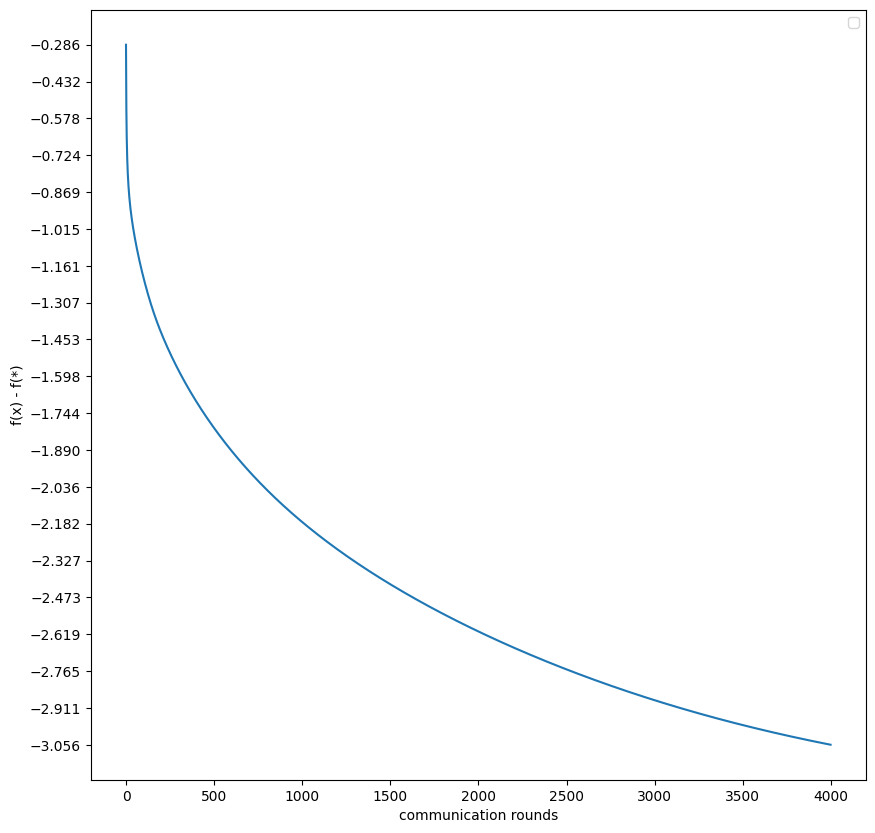

In [202]:
plt.figure(figsize=(10, 10))
local_gd_criterions = [np.log10(c) for c in local_gd_criterions]
plt.yticks(np.linspace(np.min(local_gd_criterions), np.max(local_gd_criterions), num=20))
plot_iterations(criterions=local_gd_criterions, x_label='communication rounds', y_label='f(x) - f(*)', show=True)

In [203]:
class ProxSkipDevice:
    def __init__(self,
                 function: callable, 
                 gradient_function: callable, 
                 data: np.ndarray,
                 labels: np.ndarray,
                 xt: np.ndarray,
                 ht: np.ndarray
                 ) -> None:
        self.data = data
        self.labels = labels

        self.function = function
        self.gradient_function = gradient_function 

        # the control variate
        self.ht = ht
        # the weight
        self.xt = xt

    def grad_step(self, step_size: float, x_current: np.ndarray = None) -> np.ndarray:
        d, l = self.data, self.labels
        
        if x_current is None:
            # this calculates the gradient and updates the local weight
            grad = self.gradient_function(d, l, self.xt)
            self.xt = self.xt - step_size * (grad - self.ht)
            return self.xt
        
        else:
            return self.gradient_function(d, l, x_current)  


    def control_variate_step(self, step_size: float, xt: np.ndarray):
        self.ht = self.ht + step_size * (xt - self.xt)


    def local_function(self, x_current: np.ndarray = None):
        x_current = self.xt if x_current is None else x_current
        return self.function(self.data, self.labels, x_current)


    def local_grad(self, x_current: np.ndarray = None) -> np.ndarray:
        x_current = self.xt if x_current is None else x_current
        return self.gradient_function(self.data, self.labels, x_current)

    def set_xt(self, x: np.ndarray):
        self.xt = x.copy()

    def set_ht(self, h: np.ndarray):
        self.ht = h.copy()
    


In [204]:
def setup_hts_prox_skip(shape: Tuple, number: int):
    np.random.seed(55)
    hts = [np.random.randn(*shape) for _ in range(number)]
    avg = np.mean(hts, axis=0)    
    assert np.allclose(np.sum(np.asarray([h - avg for h in hts]), axis=0), 0), "The sum of hts do not add up to a 'zero' vector."
    return [h - avg for h in hts]
# def setup_xts_prox_skip(shape: Tuple, number: int):
#     np.random.seed(14)
#     x0 = np.random.randn(*shape)
#     return [x0 for _ in range(number)]
    
# HTS = setup_hts_prox_skip((DATA.shape[1], 1), NUM_DEVICES)
# XTS = setup_xts_prox_skip((DATA.shape[1], 1), NUM_DEVICES)


# print(HTS[0].shape)

# # set the devices
# PROXSKIP_DEVICES = [ProxSkipDevice(function=FUNCTION,
#                                    gradient_function=GRADIENT_FUNCTION,
#                                    data=d_data,
#                                    labels=d_labels, 
#                                    xt=xt, 
#                                    ht=ht) 
#                                    for (d_data, d_labels, xt, ht) in zip(DEVICES_DATA, DEVICES_LABELS, XTS, HTS)]


In [205]:
def proxSkipFL(
    devices_data,
    devices_labels,
    function: callable,
    gradient_function: callable,
    skip_probability: float,
    communication_rounds: int,
    max_iterations:int,
    x_0: np.ndarray,
    x_sol: np.ndarray=None,
    eps: float = 10 ** -5, 
    mode: str = normalized_criterion,
    gamma_k: callable = None,                      
    return_history: bool = True):
    
    random.seed(69)
    # the first step is to make sure the 'mode' variable is defined above
    if isinstance(mode , str) and mode not in [f_diff, x_diff, normalized_criterion, x_opt_diff]:
        raise ValueError((f"the variable 'mode' is expected to belong to {[f_diff, x_diff, normalized_criterion, x_opt_diff]}"
                          f"Found: {mode}"))
    
    if mode == x_opt_diff and x_sol is None: 
        raise ValueError(f"using mode = {x_opt_diff} requires passing the solution to the problem")

    hts = setup_hts_prox_skip((devices_data[0].shape[1], 1), len(devices_data))
    xts = [x_0.copy() for _ in range(len(devices_data))]

    x_current = np.expand_dims(x_0) if x_0.ndim == 1 else x_0
    x_history = [x_current]
    criterion_history = []
    cs = 0

    for k in tqdm(range(max_iterations)):
        x_previous = x_current.copy()
        # find the value of gamma
        gamma = gamma_k(k)

        # iterate through the data
        for index, (d_data, d_labels) in enumerate(zip(devices_data, devices_labels)):
            xts[index] = xts[index] - gamma * (gradient_function(d_data, d_labels, xts[index]) - hts[index])

        # decide whether to prox or not
        on_prox = random.random() < skip_probability

        if on_prox:
            cs += 1
            # calculate the average xt
            avg_xt = np.mean(xts, axis=0).reshape(-1, 1)
            # avg_xt = np.concatenate(xts, axis=1).mean(axis=1).reshape(-1, 1)

            assert avg_xt.shape == (devices_data[0].shape[1], 1), f"Make sure the averaging operation is correct. Found shape: {avg_xt.shape}"

            # update the controle variate
            for index in range(len(hts)):
                hts[index] = hts[index] + (skip_probability / gamma) * (avg_xt - xts[index])
            
            # set xts
            xts = [avg_xt.copy() for _ in xts]

            x_current = avg_xt.copy()
            # update the control variate
            
            if mode == f_diff:
                x_current_function_value = np.mean([function(d_data, d_labels, x_current) for d in devices_data])
                x_previous_function_value = np.mean([function(d_data, d_labels, x_previous) for d in devices_data])
                # the value of the function at 'x_current' is the average of the values of the local functions both at 'x_current' and 'x_previous'
                diff = f_difference(x_current_function_value, x_previous_function_value)
            
            elif mode == x_diff:
                diff = x_difference(x_current, x_previous)
            
            elif mode == normalized_criterion:
                # calculate the gradient at 'x_current' which is already calculated
                grad_x0 = np.concatenate(
                    [gradient_function(d_data, d_labels, x_0) for d_data, d_labels in zip(devices_data, devices_labels)]
                    ).mean(axis=1).reshape(-1, 1)
                
                grad_x_current = np.concatenate([gradient_function(d_data, d_labels, x_current) 
                                                        for d_data, d_labels in zip(devices_data, devices_labels)]).mean(axis=1).reshape(-1, 1)
                
                diff = norm(grad_x_current) / norm(grad_x0)
            
            elif mode == x_opt_diff: 
                diff = norm(x_current - x_sol, ord=2)
            
            else: 
                # the last case is where the criterion is passed as an argument
                diff = mode(x_current)

            criterion_history.append(diff)
            # add 'x_current' to the history
            x_history.append(x_current)
                
            if diff <= eps: 
                break
            
            if communication_rounds == cs :
                break

    return  (x_history, criterion_history) if return_history else x_history[-1]


In [206]:
# def proxSkipFL(
#         local_devices: List[ProxSkipDevice],
#         skip_probability: float,
#         communication_rounds: int,
#         max_iterations:int,
#         x_0: np.ndarray,
#         x_sol: np.ndarray=None,
#         eps: float = 10 ** -5, 
#         mode: str = normalized_criterion,
#         gamma_k: callable = None,                      
#         return_history: bool = True):
#     # the first step is to make sure the 'mode' variable is defined above
#     if isinstance(mode , str) and mode not in [f_diff, x_diff, normalized_criterion, x_opt_diff]:
#         raise ValueError((f"the variable 'mode' is expected to belong to {[f_diff, x_diff, normalized_criterion, x_opt_diff]}"
#                           f"Found: {mode}"))
    
#     if mode == x_opt_diff and x_sol is None: 
#         raise ValueError(f"using mode = {x_opt_diff} requires passing the solution to the problem")

#     # set the initial value for all devices
#     for d in local_devices:
#         d.set_xt(x_0)

#     x_current = np.expand_dims(x_0) if x_0.ndim == 1 else x_0
#     x_history = [x_current]
#     criterion_history = []
#     cs = 0

#     for k in tqdm(range(max_iterations)):
#         x_previous = x_current.copy()
#         learning_rate = gamma_k(k)

#         # local step for each device
#         local_xs = [d.grad_step(step_size=learning_rate) for d in local_devices]
        
#         # flip a coin: whether to communicate or not
#         on_prox = random.random() < skip_probability
        
#         if not on_prox:
#             continue

#         if on_prox:
#             communications += 1

#             # average the local xs
#             avg_x = np.concatenate(local_xs, axis=1).mean(axis=1).reshape(-1, 1)
            
#             for d in local_devices:
#                 d.control_variate_step(step_size= (skip_probability / learning_rate), xt=avg_x)
#                 # set x_t
#                 d.set_xt(x=avg_x)

#             x_current = avg_x.copy()
#             # update the control variate
            
#             if mode == f_diff:
#                 # the value of the function at 'x_current' is the average of the values of the local functions both at 'x_current' and 'x_previous'
#                 x_current_function_value = np.mean([d.local_function(x_current=x_current) for d in local_devices])
#                 x_previous_function_value = np.mean([d.local_function(x_current=x_previous) for d in local_devices])    
#                 diff = f_difference(x_current_function_value, x_previous_function_value)
            
#             elif mode == x_diff:
#                 diff = x_difference(x_current, x_previous)
            
#             elif mode == normalized_criterion:
#                 # calculate the gradient at 'x_current' which is already calculated
#                 local_grads_x0 = np.concatenate([d.local_grad(x_current=x_0) for d in local_devices], axis=1)
#                 x0_grad = np.mean(local_grads_x0, axis=1).reshape(-1, 1)

#                 local_grads_x0 = np.concatenate([d.local_grad(x_current=x_current) for d in local_devices], axis=1)
#                 current_grad = np.mean(local_grads_x0, axis=1).reshape(-1, 1)
                
#                 diff = norm(current_grad) / norm(x0_grad)
            
#             elif mode == x_opt_diff: 
#                 diff = norm(x_current - x_sol, ord=2)
            
#             else: 
#                 # the last case is where the criterion is passed as an argument
#                 diff = mode(x_current)

#             criterion_history.append(diff)
#             # add 'x_current' to the history
#             x_history.append(x_current)
                
#             if diff <= eps: 
#                 break

#             if communication_rounds == communications:
#                 break

#     return  (x_history, criterion_history) if return_history else x_history[-1]

In [207]:
PROX_SKIP_PROBABILITY = np.sqrt(PROBLEM_LAMBDA / PROBLEM_L)
PROX_SKIP_K =  K ** 2# 10 ** 5 # int(math.ceil(COMMUNICATION_ROUNDS / PROX_SKIP_PROBABILITY))
PROX_SKIP_PROBABILITY

0.01

In [208]:
prox_xpoints, prox_criterions = proxSkipFL(
            devices_data=DEVICES_DATA, 
            devices_labels=DEVICES_LABELS,
            function=FUNCTION,
            gradient_function=GRADIENT_FUNCTION,
            skip_probability=PROX_SKIP_PROBABILITY, 
            communication_rounds=COMMUNICATION_ROUNDS,
            x_0=set_up(), 
            max_iterations=PROX_SKIP_K, 
            gamma_k=lambda _ : 1 / PROBLEM_L,
            mode=CRITERION
            )

  0%|          | 392039/10000000000 [23:28<9982:44:01, 278.25it/s] 


In [209]:
# convert to np.log
prox_criterions = [np.log10(max(c, 10 ** -8)) for c in prox_criterions]

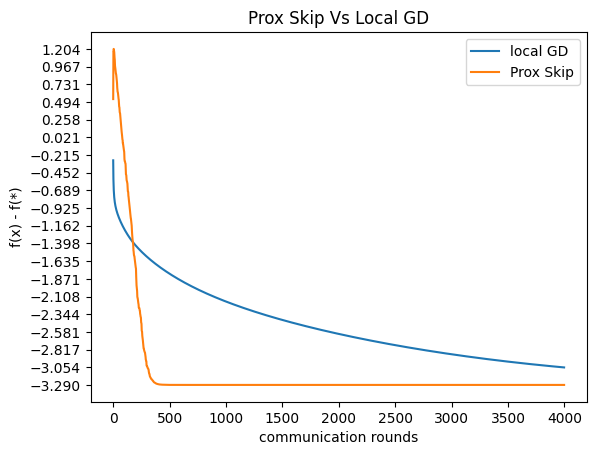

In [210]:
plot_iterations(criterions=local_gd_criterions, x_label='communication rounds', y_label='f(x) - f(*)', 
                plot_label='local GD',
                show=False)

plot_iterations(criterions=prox_criterions, x_label='communication rounds', y_label='f(x) - f(*)', 
                plot_label='Prox Skip',
                show=False)

plt.yticks(np.linspace(
                        start=min(np.min(prox_criterions), np.min(local_gd_criterions)), 
                        stop=max(np.max(prox_criterions), np.max(local_gd_criterions)),num=20
                                 ))
plt.legend()
plt.title('Prox Skip Vs Local GD')
plt.show()